In [18]:
##Various imports##
import pylab
import random
import math
from __future__ import division

from pandas import *
from pylab import *
from numpy import *
import numpy as numpy
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import sklearn as sklearn
import matplotlib.cm as cm
import matplotlib.pyplot as pyplot
%matplotlib inline


######Clean, more structured version of metacriticReviews2.ipynb######

######Need to replace the file path directory to use the read_csv######

#metacriticReviews.csv is data I captured from building a scraper and crawling through the following pages
#http://www.metacritic.com/browse/games/score/metascore/all/all/filtered?sort=desc


#Each instance in the dataframe is one video game. Each video game contains the following attributes:
#title (name of the game) 
#release (day the game was published for sale in North America)
#platform (the console that the video game release on. **Note: Games may appear multiple times due to multiple console-release. Often game release on different consoles have slightly different experiences.
#rating (the ESRB rating of the game. Rates games based on appropriate consumer audience)
#publisher (company that published the game)
#genre (genre(s) pertaining to the game.)
#metascore (aggregate media and critic score of the game. Aggregate based on numerous media outlets and publications)
#userscore (aggregate metacritic community score of the game. Metacritic users may award any game a score, which is the added to the average that makes up the userscore)

###Eventually, the goal here is to try and come up with a model that will predict what the metascore of new games will be in the future
###Because I'm trying to predict the future metascore of these games, I believe the most appropriate tool would be to look at a regression model


##Handles all of the general preprocessing work##
class metacriticProcessing:
    
    def __init__(self):pass
    
    def readCSV(self):
        gameData = read_csv("/Users/JuupoMac/Desktop/gamedata/metacritic.csv")
        return gameData
    
    def cleanUp(self, gameData):
        #Drops pagintation features - were generated in the scraper
        gameData.drop(['pagination', 'pagination-href'], axis = 1, inplace=True)
        
        #dropping title in favor of setting it as an index
        colName =gameData.columns[0]
        gameData=gameData.rename(columns = {colName:'title'})
        gameData.set_index(gameData.title)
        gameData = gameData.drop('title', 1)
        
        #For date, I'd like to keep things simple for this project and convert it to the pandas ordinal format
        #Makes it usable in analysis
        gameData['release'] =  pandas.to_datetime(gameData['release'])
        gameData.release = gameData['release'].apply(lambda x: x.toordinal())
        
        #After taking a quick look through the data I've noticed that there are plenty of instances with missing data
        #Here I am going to try out a technique to impute the missing data based on a median of userscores
        #I'm aware that there are 'better' ways of completing this, but for now, I think a median of userscores will work for this project
        #I'd like to come back to this section soon and try either a KNN imputation or something more complex
        
        #Preparing to replace TBD values of userscore with an imputed value. Need to replace all instances of 'tbd' in userscore with '0.0'
        #After replacing, I can recast all of the values as floats and impute new values into the userscore
        #Need to cover two cases: tbd (no pending reviews) and null (missing data for whatever reason)

        gameData['userscore'] = gameData['userscore'].str.replace('tbd', '0.0')
        gameData['userscore'] = gameData['userscore'].str.replace('null', '0.0')

        #cast all userscore values to float
        gameData.userscore = gameData.userscore.astype(float)

        #Now that all of the data in userscores is a float, I can replace the 0.0 scores with the median of userscore 
        mostFreqScore = gameData['userscore'].median()
        gameData.userscore.replace(0.0, mostFreqScore, inplace=True)
        
        #Casting the metascore attributes to floats
        gameData.metascore = gameData.metascore.astype(float)

        #converting all userscores to a 100 point scale system. Currently, the user scores are on a 10point scale. This will be useful in graphing
        gameData.userscore = gameData.userscore.multiply(10)
        
        #Keep genre simple and limit each game to its most appropriate genre
        gameData['genres'] = gameData['genres'].apply(lambda x: x.split(',')[0])
        

       
        #Calls a simple function that returns if the game is a console or a handheld and then creates a new feature
        #based on that value
        gameData['gameType'] = gameData.apply(self.gameType, axis=1)
        
        #Now that I've created an attribute for game type, clustering may be more insightful
        #I expect clustering to be based on platform or even genre. 
        #I'm exploring the difference between clustering with only numeric values, and clustering with categorical values

        #Replace null in game ratings
        gameRatingList = ['AO','E', 'E10+', 'K-A', 'M', 'RP', 'T']
        
        #gameData['rating'] = gameData['rating'].str.replace('null', random.random.choice(gameRatingList))
        gameData.loc[gameData['rating'] == 'null','rating'] = gameData['rating'].apply(lambda x: random.choice(gameRatingList))

        #Replace null in game genres
        gameGenresList = ['Action','Action Adventure','Adventure','Driving','First-Person', 'Miscellaneous','Role-Playing','Simulation','Sports','Strategy']
        
        #gameData['genres'] = gameData['genres'].str.replace('null', random.choice(gameGenresList))
        gameData.loc[gameData['genres'] == 'null','genres'] = gameData['genres'].apply(lambda x: random.choice(gameGenresList))


        #Drop publishers, converting it to numeric data is just not practical as it causes 1305 attributes
        gameData.drop(['publisher'], axis = 1, inplace=True)

        #####reserving original data here#####
        gameDataNum = gameData
        
        #Turning the categorial data to binary dummy variables
        gameDataNum = pandas.get_dummies(gameDataNum, columns = ['platform', 'rating','genres', 'gameType'])
        
        #casting the dataset to numeric values to catch any non-ints
        gameDataNum['release'] = gameDataNum['release'].astype(int)
        gameDataCleaned = gameDataNum.apply(lambda x: pandas.to_numeric(x, errors='ignore'))
        
        return gameDataCleaned
        
    #function to return whether or not the game is a handheld or a console game    
    def gameType(self, data):
        if data.platform == 'DS': 
            return 'handheld'
        elif data.platform == 'PSP': 
            return 'handheld'
        elif data.platform == 'VITA': 
            return 'handheld'
        elif data.platform == '3DS': 
            return 'handheld'
        elif data.platform == 'GBA': 
            return 'handheld'
        else:
            return 'console'
        
####Now perform some actual clustering on the metacritic reviews data#####
#####Utilizing to use sklearn's silhouette analysis to find the determine number of clusters#####
#####and then visualize the results#####
    def metacriticClustering(self, gameDataPrepared):
        #Shortened, not necessary to have that many cluster choices when n=2 is optimal using this analysis
        nClusters = [2,3,4,5]
 
        #going to build a few subplots to show each cluster size/plot and the silhouette score/plot of each cluster size
        #Draws subplots, 2 plots per nCluster value and then fits the kMeans clustering algorithm to the data
        #Computers the silhouette values for cluster n and then finds the silhouette average
        #Helps determine the correct n cluster

        for n in nClusters:
            #ax1 is the silhouette subplot
            #ax2 is the cluster subplot
            figure, (ax1, ax2) = pyplot.subplots(1,2)
            figure.set_size_inches(18,7)
    
            #providing some blank space between plots
            ax1.set_ylim([0, len(gameDataPrepared) + (n+1) *10])
    
            #here the kMeans cluster is initialized with nClusters
            cluster = KMeans(n_clusters = n)
            cluster.fit(gameDataPrepared)
            clusterLabels = cluster.predict(gameDataPrepared)
    
            #compute the silhouette scores for each sample
            silhouetteVals = silhouette_samples(gameDataPrepared, clusterLabels)
    
            #silhouette score for all samples
            silhouetteAvg = silhouette_score(gameDataPrepared, clusterLabels)
            print 'For n clusters = ', n , 'The average silhouette score is: ' , silhouetteAvg
    
    
            #For loop that calculates the cluster values and labels and then fills the graph for nClusers = i
            yLow = 10
            for i in range(n):
                #Collect silhouette scores for each sample and sort them
                clusterSilhouetteVals = silhouetteVals[clusterLabels == i]
                clusterSilhouetteVals.sort()
        
                clusterSize = clusterSilhouetteVals.shape[0]
                yHigh = yLow + clusterSize
        
                color = cm.spectral(float(i)/n)
                ax1.fill_betweenx(numpy.arange(yLow, yHigh), 0, clusterSilhouetteVals, facecolor = color, edgecolor = color, alpha = .7)
        
                #label silhouette plots with cluster numbers in the center
                ax1.text(-0.05, yLow + .5 * clusterSize, str(i))
        
                #compute new yLow for the next plot
                yLow = yHigh + 10 
        
            ax1.set_title("The Silhouette Plot for Clusters")
            ax1.set_xlabel("The Silhouette Coefficient Values")
            ax1.set_ylabel("Cluster Label")
        
            #draw a vertical line that represents the average silhouette score for n clusters
            ax1.axvline(x = silhouetteAvg, color = "blue", linestyle = "--")
        
            #Labeling axis
            ax1.set_yticks([])
            ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        
            #Cluster Results Plot
            colors = cm.spectral(clusterLabels.astype(float)/n)
            ax2.scatter(gameDataPrepared.release, gameDataPrepared.metascore, marker = '.', s = 30, lw = 0, alpha = .7, c = colors)
        
            #label the clusters
            centers = cluster.cluster_centers_
            #draw circles at cluster centers
            ax2.scatter(centers[:, 0], centers[:,1], marker = 'o', c = "white", alpha = 1, s = 200)
    
            #Mark the scatter plot with the centers of the clusters
            for i, c in enumerate(centers):
                ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, s = 50)
            
            #Finishing touches on the labels of the graph    
            ax2.set_title("Visualization of the Clustered Data.")
            ax2.set_xlabel("Feature space for Release")
            ax2.set_ylabel("Feature space for Metascore")
        
            pyplot.suptitle(("Silhoutte Analysis for KMeans Clustering on Metacritic Review Data with nClusters = %d" %n), fontsize = 16, fontweight = 'bold')
            pyplot.show()
            
        return None
    
    def metacriticCoefficientTesting(self, gameDataReg):
        
        #I'd like to perform a simple regression to try and predict the metascore of a game
        #Build the model with the training data I have and then take games with an unknown metascore in the future and try to predict that scor

        #Store metascore in an array and drop metascore from the data
        metascoreArray = gameDataReg.metascore
        gameDataReg = gameDataReg.drop('metascore', axis =1)
        
        #Create an instance of sklearn's Linear Regression
        regress = LinearRegression()
        
        #Fit the data to the model
        regress.fit(gameDataReg, metascoreArray)
        
        #Print intercept coefficient and number of feature coefficients
        print "Estimated Intercept Coefficient: " , regress.intercept_
        print "Number of Coefficients: " , len(regress.coef_)
        
        #Put the coefficients for each feature in a dataframe to look at what impacts metascore the most
        coefficientFeatures = pandas.DataFrame(zip(gameDataReg.columns, regress.coef_), columns = ["features", "coefficients"])
        return coefficientFeatures
    
    def metacriticLinearRegression(self, gameDataReg):
        
        metascoreArray = gameDataReg.metascore
        gameDataReg = gameDataReg.drop('metascore', axis =1)
        # x = independent variables
        # y = dependent variable (metascore)
        #Now I'd like to split the data into a training and testing set randomly to try and predict the metascore
        #This is to simulate using a training dataset to learn the model
        #and then use the model to predict metascore on future samples/obvservations
        #Using the code directly below, this creates x and y training data, and x and y test data randomly
        #Prevents the training/test data from being skewed in one particular direction
        XTrain, XTest, YTrain, YTest = sklearn.cross_validation.train_test_split(gameDataReg, metascoreArray, test_size = .33, random_state =5)
        
        #Create an instance of sklearn's Linear Regression, fit the data and predict on the training and on the test data
        regress2 = LinearRegression()
        regress2.fit(XTrain, YTrain)
        predictTrain = regress2.predict(XTrain)
        predictTest = regress2.predict(XTest)
        
        #Print the Mean Squared Errors of the Training and Test Data, then plot the results
        print "Mean Squared Error of the training data: ", numpy.mean((YTrain - predictTrain) ** 2)
        print "Mean Squared Error of the test data: " , numpy.mean((YTest - predictTest) ** 2)
        
        #Plotting the residuls to see if they are scattered around 0
        pyplot.scatter(predictTrain, predictTrain - YTrain, c='blue', s=40, alpha = .5)
        pyplot.scatter(predictTest, predictTest - YTest, c='green', s=40)
        pyplot.hlines(y=0, xmin=0, xmax=50, color = "black", linestyle = 'solid')
        pyplot.title("Residuals Plot: Training (Blue) and Test (Green)")
        pyplot.ylabel("Residuals")

For n clusters =  2 The average silhouette score is:  0.602077726397


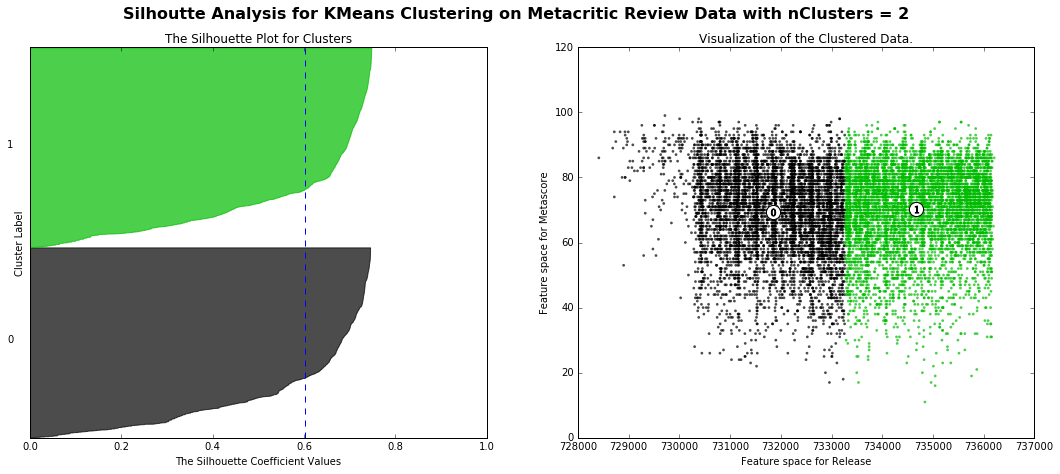

For n clusters =  3 The average silhouette score is:  0.578910690477


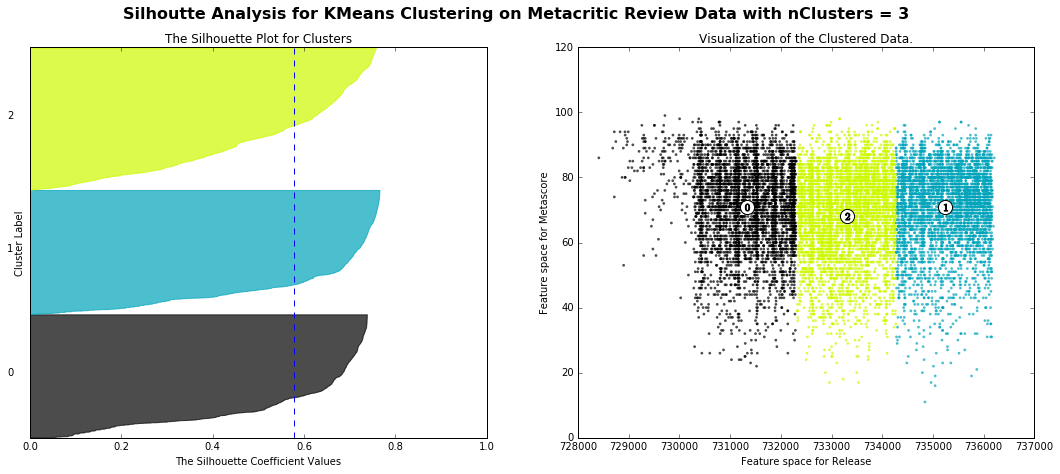

For n clusters =  4 The average silhouette score is:  0.56701097396


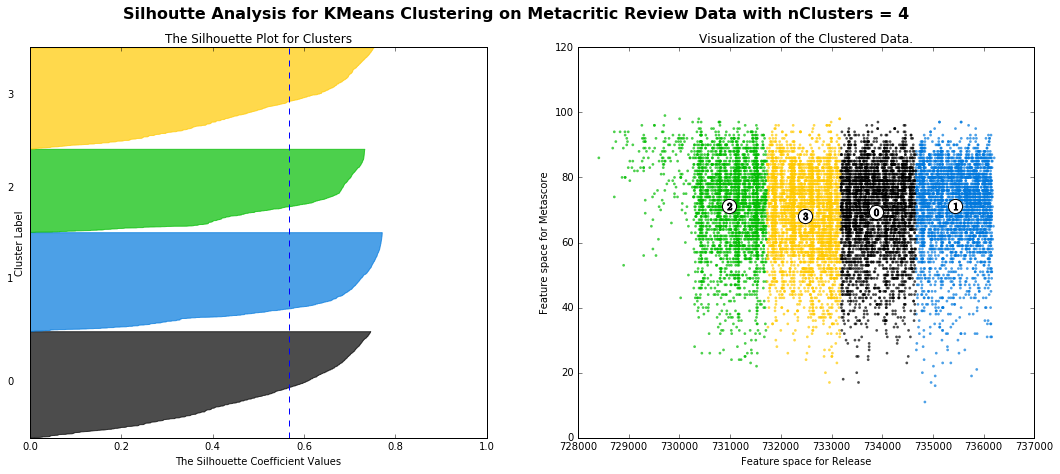

For n clusters =  5 The average silhouette score is:  0.551825023295


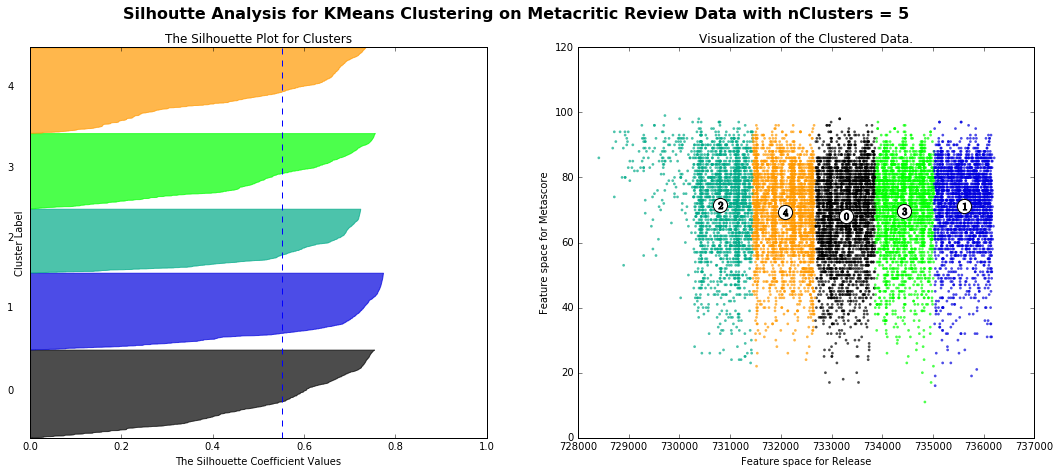

In [19]:
###Calls to perform clustering with silhouette analysis###
analysis = metacriticProcessing()
data = analysis.readCSV()
cleanedData = analysis.cleanUp(data)
analysis.metacriticClustering(cleanedData)

In [11]:
###Calls to perform linear regression and look at coefficient values for each feature against metascore###
analysis2 = metacriticProcessing()
data = analysis2.readCSV()
cleanedData = analysis2.cleanUp(data)
analysis2.metacriticCoefficientTesting(cleanedData)

Estimated Intercept Coefficient:  -542.399603556
Number of Coefficients:  39


,features,coefficients
0,release,0.000777
1,userscore,0.581749
2,platform_3DS,-0.139003
3,platform_DC,1.501796
4,platform_DS,-1.718699
5,platform_GBA,-0.741431
6,platform_GC,-0.860733
7,platform_N64,4.890836
8,platform_PC,0.974333
9,platform_PS,0.158832


Mean Squared Error of the training data:  108.495796418
Mean Squared Error of the test data:  111.252541706


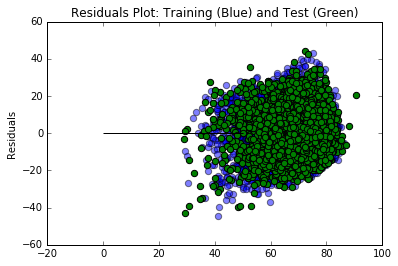

In [17]:
###Calls to perform linear regression training and test data and compare the mean squared error of both###
analysis3 = metacriticProcessing()
data = analysis3.readCSV()
cleanedData = analysis3.cleanUp(data)
analysis3.metacriticLinearRegression(cleanedData)